<a href="https://colab.research.google.com/github/lemonyun/keras_study/blob/main/5_3_using_a_pretrained_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#사전 훈련된 네트워크 사용하기
학습된 특성을 다른 문제에 적용할 수 있는 유연성은 이전의 많은 얕은 학습 방법과 비교했을 때 딥러닝의 핵심 장점입니다.
사전 훈련된 네트워크를 사용하는 두 가지 방법
1. 특성 추출
2. 미세 조정

특성 추출의 경우 사전에 훈련된 네트워크의 합성곱 기반층을 선택해 새로운 데이터를 통과시키고 그 출력으로 새로운 분류기를 훈련

완전 연결 분류기를 바꾸는 느낌

합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용 가능하기 때문입니다. 컨브넷의 특성 맵은 사진에 대한 일반적인 컨셉의 존재 여부를 기록한 맵입니다. 그래서 주어진 컴퓨터 비전 문제에 상관없이 유용하게 사용할 수 있습니다. 하지만 분류기에서 학습한 표현은 모델이 훈련된 클래스 집합에 특화되어 있습니다.

ImageNet 데이터셋에 훈련된 VGG16 네트워크의 합성곱 기반층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출해 보겠습니다.

In [1]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

두 가지 방식이 가능
1. 새로운 데이터셋에서 합성곱 기반층을 실행하고 출력을 넘파이 배열로 디스크에 저장합니다. 하지만 데이터 증식을 사용할 수 없음

2. 준비한 모델(conv_base) 위에 Dense 층을 쌓아 확장합니다. 그다음 입력 데이터에서 엔드 투 엔드로 전체 모델을 실행합니다. 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과하기 때문에 데이터 증식을 사용할 수 있습니다. 하지만 이런 이유로 이 방식은 첫 번째 방식보다 훨씬 비용이 많이 듭니다.


##첫 번째 방식

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


ImageDataGenerator를 사용해 이미지와 레이블을 넘파이 배열로 추출하겠습니다. conv_base 모델의 predict 메서드를 호출하여 이 이미지에서 특성을 추출합니다.

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './gdrive/MyDrive/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

두 개의 Dense 층만 처리하면 되기 때문에 훈련이 매우 빠릅니다. CPU를 사용하더라도 한 에포크에 걸리는 시간이 1초 미만입니다.

In [8]:
from keras import models
from keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 6ms/step - loss: 0.6048 - acc: 0.6770 - val_loss: 0.4423 - val_acc: 0.8270
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4244 - acc: 0.8075 - val_loss: 0.3601 - val_acc: 0.8760
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3589 - acc: 0.8475 - val_loss: 0.3299 - val_acc: 0.8720
Epoch 4/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3088 - acc: 0.8720 - val_loss: 0.2981 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2854 - acc: 0.8855 - val_loss: 0.2814 - val_acc: 0.8870
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2680 - acc: 0.8950 - val_loss: 0.2695 - val_acc: 0.8920
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2413 - acc: 0.9060 - val_loss: 0.2604 - val_acc: 0.8930
Epoch 8/30
100/100 [==============================] - 0s 5ms/step - loss: 0.

In [9]:
import matplotlib.pyplot as plt

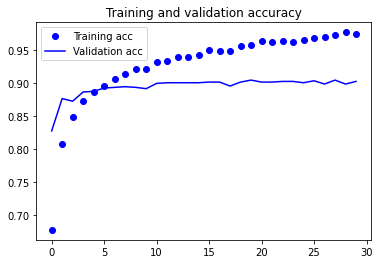

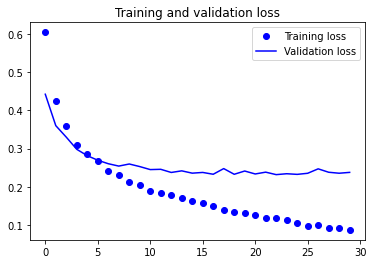

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

약 90%의 검증 정확도에 도달했습니다. 이전 절에서 처음부터 훈련시킨 작은 모델에서 얻은 것보다 훨씬 좋습니다. 하지만 이 그래프는 많은 비율로 드롭아웃을 사용했음에도 불구하고 훈련이 시작하면서 거의 바로 과대적합되고 있다는 것을 보여줍니다. 작은 이미지 데이터셋에서는 과대적합을 막기 위해 필수적인 데이터 증식을 사용하지 않았기 때문입니다.

작은 이미지 데이터셋에서는 과대적합을 막기 위해 필수적인 데이터 증식을 사용하지 않았기 때문에 과대적합이 일어남

두 번째 방법은 훨씬 느리고 비용이 많이 들지만 훈련하는 동안 데이터 증식 기법을 사용할 수 있음

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


모델을 컴파일하고 훈련하기 전에 합성곱 기반층을 동결하는 것이 아주 중요합니다. 하나 이상의 층을 동결한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻입니다. **이렇게 하지 않으면 합성곱 기반층에 의해 사전에 학습된 표현이 훈련하는 동안 수정될 것입니다. 맨 위의 Dense 층은 랜덤하게 초기화되었기 때문에 매우 큰 가중치 업데이트 값이 네트워크에 전파될 것입니다.** 이는 사전에 학습된 표현을 크게 훼손하게 됩니다.

In [13]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [14]:
conv_base.trainable = False

Dense 층마다 두개씩 해서 4개(가중치 행렬과 편향 벡터)

In [15]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [17]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
100/100 - 26s - loss: 0.4908 - acc: 0.7815 - val_loss: 0.3835 - val_acc: 0.8490 - 26s/epoch - 260ms/step
Epoch 2/30
100/100 - 22s - loss: 0.3925 - acc: 0.8360 - val_loss: 0.3237 - val_acc: 0.8860 - 22s/epoch - 223ms/step
Epoch 3/30
100/100 - 23s - loss: 0.3435 - acc: 0.8540 - val_loss: 0.2961 - val_acc: 0.8920 - 23s/epoch - 226ms/step
Epoch 4/30
100/100 - 22s - loss: 0.3237 - acc: 0.8660 - val_loss: 0.2757 - val_acc: 0.8950 - 22s/epoch - 220ms/step
Epoch 5/30
100/100 - 22s - loss: 0.2890 - acc: 0.8815 - val_loss: 0.2611 - val_acc: 0.8970 - 22s/epoch - 221ms/step
Epoch 6/30
100/100 - 22s - loss: 0.2865 - acc: 0.8825 - val_loss: 0.2540 - val_acc: 0.9010 - 22s/epoch - 221ms/step
Epoch 7/30
100/100 - 22s - loss: 0.2771 - acc: 0.8895 - val_loss: 0.2502 - val_acc: 0.9000 - 22s/epoch - 220ms/step
Epoch 8/30
100/100 - 22s - loss: 0.2737 - acc: 0.8900 - val_loss: 0.2428 - val_acc: 0.9060 - 22s/epoch - 221ms/step
Epoch 9/30
100/100 - 22s - loss: 0.2563 - acc: 0.8910 - val_loss: 0.2390

In [18]:
model.save('cats_and_dogs_small_3.h5')

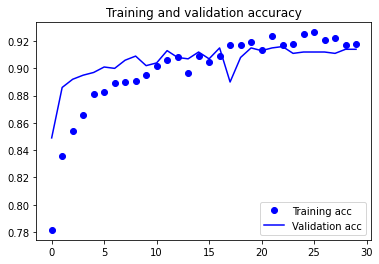

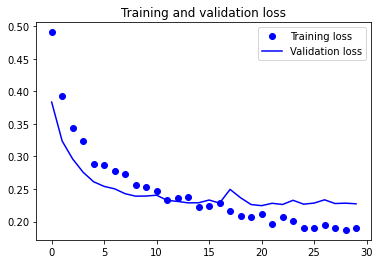

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#미세 조정

특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층과 함께 훈련하는 것(재사용 모델의 표현을 일부 조정)






1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가합니다.
2. 기반 네트워크를 동결합니다.
3. 새로 추가한 네트워크를 훈련합니다.
4. 기반 네트워크에서 일부 층의 동결을 해제합니다.
5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련합니다.

In [20]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

##적은 층을 미세조정 하는이유

* 합성곱 기반층에 있는 하위 층들은 좀 더 일반적이고 재사용 가능한 특성들을 
인코딩합니다. 반면 상위 층은 좀 더 특화된 특성을 인코딩합니다. **새로운 문제에 재활용하도록 수정이 필요한 것은 구체적인 특성이므로 이들을 미세 조정하는 것이 유리합니다.** 하위 층으로 갈수록 미세 조정에 대한 효과가 감소합니다.
* 훈련해야 할 **파라미터가 많을수록 과대적합의 위험이 커집니다.** 합성곱 기반층은 1천 5백만 개의 파라미터를 가지고 있습니다. 작은 데이터셋으로 전부 훈련하려고 하면 매우 위험합니다.

최상위 3개의 층만 학습 가능하도록 함

In [21]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

학습률을 2e-5에서 e-5로 낮춤
학습된 표현을 조금씩 수정하기 위해서.. 기존에 학습된 표현에 악영향을 줄 수 있기 때문

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
100/100 [==============================] - 25s 237ms/step - loss: 0.2014 - acc: 0.9165 - val_loss: 0.2314 - val_acc: 0.9120
Epoch 2/100
100/100 [==============================] - 24s 235ms/step - loss: 0.1629 - acc: 0.9375 - val_loss: 0.2525 - val_acc: 0.8970
Epoch 3/100
100/100 [==============================] - 24s 236ms/step - loss: 0.1411 - acc: 0.9415 - val_loss: 0.2278 - val_acc: 0.9060
Epoch 4/100
100/100 [==============================] - 24s 236ms/step - loss: 0.1259 - acc: 0.9505 - val_loss: 0.2072 - val_acc: 0.9240
Epoch 5/100
100/100 [==============================] - 24s 236ms/step - loss: 0.1089 - acc: 0.9560 - val_loss: 0.1993 - val_acc: 0.9330
Epoch 6/100
100/100 [==============================] - 24s 237ms/step - loss: 0.1023 - acc: 0.9600 - val_loss: 0.2021 - val_acc: 0.9300
Epoch 7/100
100/100 [==============================] - 24s 238ms/step - loss: 0.0771 - acc: 0.9735 - val_loss: 0.1993 - val_acc: 0.9290
Epoch 8/100
100/100 [===========================

In [23]:
model.save('cats_and_dogs_small_4.h5')

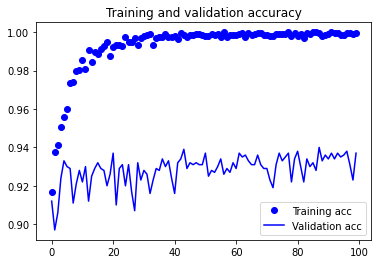

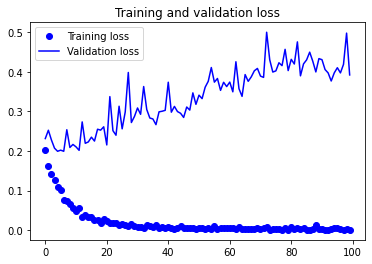

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

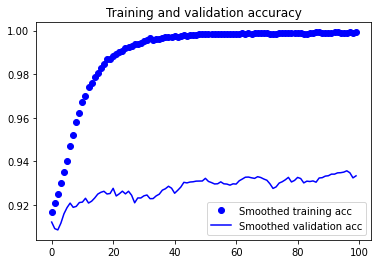

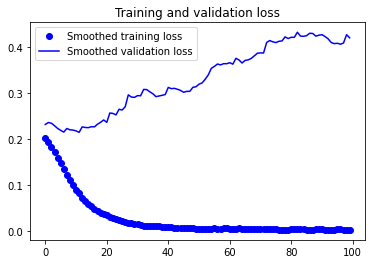

In [25]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  import sys


test acc: 0.9399999976158142


In [29]:
test_list = []
if test_list:
  print("1")
else:
  print("2")

2


###손실 곡선은 악화되었지만 정확도는 올라가는 이유

그래프는 개별적인 손실 값의 평균을 그린 것이지만 정확도에 영향을 미치는 것은 손실 값의 분포이기 때문
